# TOPIC

# predicting whether a transaction is fraud or normal

# DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes  import GaussianNB

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
import joblib

# DATASET

In [67]:
df=pd.read_csv(r"C:\Users\sumod\Downloads\payment_fraud.csv")
df

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0
...,...,...,...,...,...,...,...,...
39216,986,1,4.836982,creditcard,0.000000,shopping,0.0,0
39217,1647,1,4.876771,creditcard,377.930556,shopping,0.0,0
39218,1591,1,4.742303,creditcard,0.000000,shopping,1.0,0
39219,237,1,4.921318,creditcard,236.082639,shopping,1.0,0


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   numItems              39221 non-null  int64  
 1   localTime             39221 non-null  float64
 2   paymentMethod         39221 non-null  int32  
 3   paymentMethodAgeDays  39221 non-null  float64
 4   Category              39221 non-null  int32  
 5   isWeekend             39221 non-null  float64
 6   label                 39221 non-null  int64  
dtypes: float64(3), int32(2), int64(2)
memory usage: 1.8 MB


In [193]:
df.describe()

,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
count,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000
mean,1.084751,4.748232,0.334795,122.641326,1.015017,0.492415,0.014278
std,0.566899,0.389360,0.565965,283.569177,0.818080,0.499949,0.118636
min,1.000000,0.421214,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.742303,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.886641,0.000000,0.012500,1.000000,0.000000,0.000000
75%,1.000000,4.962055,1.000000,87.510417,2.000000,1.000000,0.000000
max,29.000000,5.040929,2.000000,1999.580556,2.000000,1.000000,1.000000


In [ ]:
#DATA VISUALISATION

<Axes: >

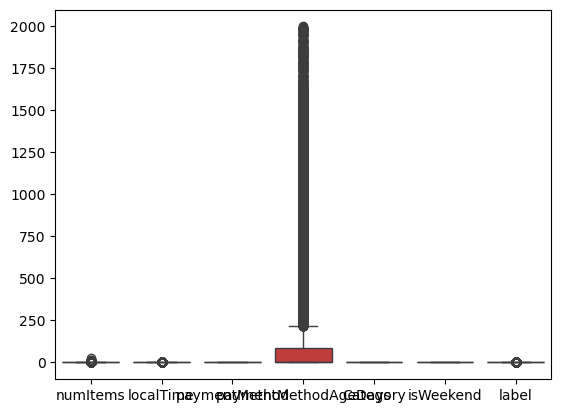

In [66]:
sns.boxplot(df)

<Axes: xlabel='label'>

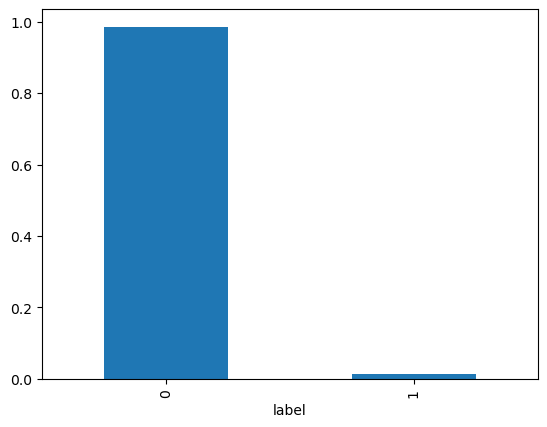

In [3]:
df['label'].value_counts(normalize=True).plot(kind='bar')

# preprocessing

In [69]:
pd.crosstab(df['accountAgeDays'] <= 1.5, df['label'])
df = df.drop(columns=['accountAgeDays'])

In [71]:
df.isnull().sum()

numItems                0
localTime               0
paymentMethod           0
paymentMethodAgeDays    0
Category                0
isWeekend               0
label                   0
dtype: int64

In [70]:
df["Category"]=df["Category"].fillna(df["Category"].mode()[0])
df["isWeekend"]=df["isWeekend"].fillna(df["isWeekend"].median())

In [72]:
lb_category=LabelEncoder()
df["Category"]=lb_category.fit_transform(df["Category"])

In [73]:
lb_payment=LabelEncoder()
df["paymentMethod"]=lb_payment.fit_transform(df["paymentMethod"])

In [74]:
df

,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,1,4.745402,1,28.204861,2,0.0,0
1,1,4.742303,2,0.000000,0,0.0,0
2,1,4.921318,0,0.000000,1,1.0,0
3,1,4.886641,0,0.000000,0,1.0,0
4,1,5.040929,0,0.000000,2,0.0,0
...,...,...,...,...,...,...,...
39216,1,4.836982,0,0.000000,2,0.0,0
39217,1,4.876771,0,377.930556,2,0.0,0
39218,1,4.742303,0,0.000000,2,1.0,0
39219,1,4.921318,0,236.082639,2,1.0,0


In [296]:
#train_test_split

In [145]:
x=df.drop("label",axis=1)
y=df["label"]

In [149]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [147]:
#data imbalance
y.value_counts()

label
0    38661
1      560
Name: count, dtype: int64

In [148]:
smote=SMOTE(random_state=42)
x_train,y_train=smote.fit_resample(x_train,y_train)
y_train.value_counts()
smote=SMOTE(random_state=42)
x_test,y_test=smote.fit_resample(x_test,y_test)
y_train.value_counts()

label
0    30928
1    30928
Name: count, dtype: int64

# 1.logmodel

In [150]:
#linear model
log_model=LogisticRegression(class_weight="balanced")
log_model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced')

In [151]:
test_pred=log_model.predict(x_test)
train_pred=log_model.predict(x_train)

In [152]:
print("test accuracy:",accuracy_score(y_test,test_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test,test_pred))
print("train accuracy:",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred))

test accuracy: 0.7365200764818356
[[5667 2066]
 [   1  111]]
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      7733
           1       0.05      0.99      0.10       112

    accuracy                           0.74      7845
   macro avg       0.53      0.86      0.47      7845
weighted avg       0.99      0.74      0.84      7845

train accuracy: 0.7287735849056604
[[22422  8506]
 [    4   444]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     30928
           1       0.05      0.99      0.09       448

    accuracy                           0.73     31376
   macro avg       0.52      0.86      0.47     31376
weighted avg       0.99      0.73      0.83     31376



In [153]:
log_model.predict([[1,4.745402,1,28.204861,2,0.0]])
log_model.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

In [228]:
joblib.dump(lb_category,"lb_category")

['lb_category']

In [78]:
joblib.dump(lb_payment,"lb_paymentmethod")

['lb_paymentmethod']

In [81]:
joblib.dump(log_model,"logmodel")

['logmodel']

In [ ]:
#tree-based models

# 2.Decisiontree

In [15]:
dt_model= DecisionTreeClassifier()

In [16]:
param_grid = {'max_depth': [5,10,50],'min_samples_leaf': [20, 50, 100],}

In [ ]:
gscv = GridSearchCV(dt_model,param_grid=param_grid,scoring='roc_auc',cv=5,return_train_score=True)

In [17]:
gscv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 50],
                         'min_samples_leaf': [20, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [18]:
print(gscv.best_params_)
print(gscv.best_score_)

{'max_depth': 50, 'min_samples_leaf': 20}
0.9888081764104978


In [154]:
dt_model=DecisionTreeClassifier(max_depth=50,min_samples_leaf=20,class_weight='balanced',random_state=42)
dt_model.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=20, random_state=42)

In [155]:
test_pred = dt_model.predict(x_test)
train_pred=dt_model.predict(x_train)
y_prob = dt_model.predict_proba(x_test)[:,1]
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.820012746972594
train accuracy 0.8211053034166241
[[6345 1388]
 [  24   88]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      7733
           1       0.06      0.79      0.11       112

    accuracy                           0.82      7845
   macro avg       0.53      0.80      0.51      7845
weighted avg       0.98      0.82      0.89      7845

ROC-AUC: 0.8290501283922337


In [156]:
dt_model.predict([[1,4.745402,1,28.204861,2,0.0]])
dt_model.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

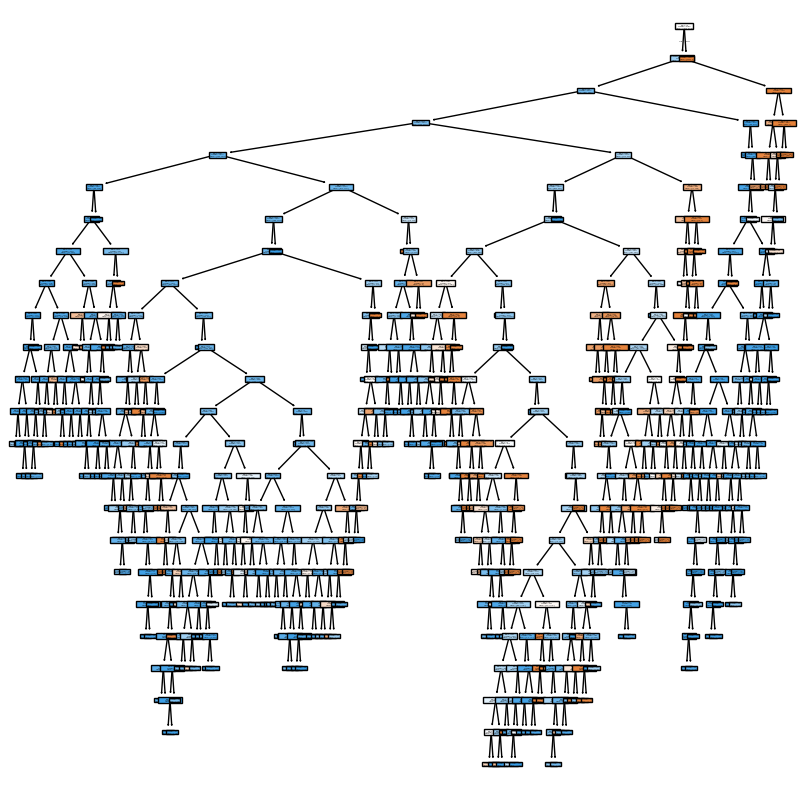

In [64]:
from sklearn import tree
fig = plt.figure(figsize=(10,10))
tree.plot_tree(dt_model,feature_names=x.columns,filled=True)
plt.show()

# 3.random forest

In [22]:
rf=RandomForestClassifier()

In [23]:
param_grid = {'n_estimators': [100, 200, 300],'max_depth': [5, 10, 50],'min_samples_leaf': [20, 50,100]}

In [24]:
gscv = GridSearchCV(rf,param_grid=param_grid,cv=5,return_train_score=True)

In [25]:
gscv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 50],
                         'min_samples_leaf': [20, 50, 100],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True)

In [26]:
print(gscv.best_params_)
print(gscv.best_score_)

{'max_depth': 50, 'min_samples_leaf': 20, 'n_estimators': 300}
0.9348488166386648


In [157]:
rf_model=RandomForestClassifier(n_estimators=300,max_depth=50,min_samples_leaf=20,class_weight='balanced',random_state=42)
rf_model.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       min_samples_leaf=20, n_estimators=300, random_state=42)

In [158]:
test_pred=rf_model.predict(x_test)
train_pred=rf_model.predict(x_train)
y_prob = rf_model.predict_proba(x_test)[:,1]

In [159]:
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.8332695984703633
train accuracy 0.8326427842937277
[[6453 1280]
 [  28   84]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      7733
           1       0.06      0.75      0.11       112

    accuracy                           0.83      7845
   macro avg       0.53      0.79      0.51      7845
weighted avg       0.98      0.83      0.90      7845

ROC-AUC: 0.9031614278324805


In [160]:
rf_model.predict([[1,4.745402,1,28.204861,2,0.0]])
rf_model.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

In [161]:
joblib.dump(rf_model,"randomforest")

['randomforest']

In [ ]:
#Random Forest is BETTER than Decision Tree

# 4.Gradient boosting

In [39]:
gb_model=GradientBoostingClassifier()

In [40]:
params={
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3]}


In [42]:
gscv=GridSearchCV(gb_model,param_grid=params,cv=5,return_train_score=True)

In [43]:
gscv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3],
                         'n_estimators': [100, 200]},
             return_train_score=True)

In [44]:
print(gscv.best_params_)
print(gscv.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
0.9252297287051843


In [162]:
gb_model=GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,max_depth=3,random_state=42)
gb_model.fit(x_train,y_train)

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [163]:
test_pred = gb_model.predict(x_test)
train_pred=gb_model.predict(x_train)
y_prob = gb_model.predict_proba(x_test)[:, 1]

In [164]:
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.9850860420650096
train accuracy 0.9873788883222846
[[7722   11]
 [ 106    6]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7733
           1       0.35      0.05      0.09       112

    accuracy                           0.99      7845
   macro avg       0.67      0.53      0.54      7845
weighted avg       0.98      0.99      0.98      7845

ROC-AUC: 0.9071205732389943


In [165]:
gb_model.predict([[1,4.745402,1,28.204861,2,0.0]])
gb_model.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

In [50]:
joblib.dump(gb_model,"gradientboost")

['gradientboost']

In [ ]:
#gradientboost is better than randomforest

# 5.XGboost

In [52]:
xg=XGBClassifier()

In [53]:
params ={'n_estimators': [100, 200],'max_depth': [3, 4],'learning_rate': [0.05, 0.1],'subsample': [0.8, 1.0],'colsample_bytree': [0.8, 1.0]}

In [54]:
gscv=GridSearchCV(xg,param_grid=params,cv=5,return_train_score=True)

In [55]:
gscv.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             return_train_score=True)

In [56]:
print(gscv.best_params_)
print(gscv.best_score_)

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
0.9239525678033189


In [166]:
xg_model=XGBClassifier(n_estimators=200,subsample=0.8,max_depth=4,learning_rate=0.1,random_state=42,colsample_bytree=1.0)
xg_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [167]:
test_pred = xg_model.predict(x_test)
train_pred= xg_model.predict(x_train)
y_prob = xg_model.predict_proba(x_test)[:, 1]


In [168]:
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.9854684512428298
train accuracy 0.9870920448750637
[[7723   10]
 [ 104    8]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7733
           1       0.44      0.07      0.12       112

    accuracy                           0.99      7845
   macro avg       0.72      0.54      0.56      7845
weighted avg       0.98      0.99      0.98      7845

ROC-AUC: 0.9041134008239271


In [39]:
xg_model.predict([[1,4.745402,1,28.204861,2,0.0]])
xg_model.predict([[4,4.836771,0,0.000000,2,0]])

array([1])

In [258]:
joblib.dump(xg_model,"xgboost")

['xgboost']

In [ ]:
#xgboost is better than gradientboost

# 6.AdaBoost

In [68]:
ada=AdaBoostClassifier()

In [69]:
params = {'n_estimators': [100, 200]}

In [70]:
gscv=GridSearchCV(ada,param_grid=params,return_train_score=True)

In [71]:
gscv.fit(x_train,y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [100, 200]}, return_train_score=True)

In [72]:
print(gscv.best_params_)
print(gscv.best_score_)

{'n_estimators': 200}
0.8993146079698976


In [136]:
ada_model=AdaBoostClassifier(n_estimators=200,random_state=42)
ada_model.fit(x_train,y_train)

AdaBoostClassifier(n_estimators=200, random_state=42)

In [137]:
test_pred=ada_model.predict(x_test)
train_pred=ada_model.predict(x_train)
y_prob=ada_model.predict_proba(x_test)[:,1]

In [138]:
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.9861057998725302
train accuracy 0.9858809280979093
[[7731    2]
 [ 107    5]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7733
           1       0.71      0.04      0.08       112

    accuracy                           0.99      7845
   macro avg       0.85      0.52      0.54      7845
weighted avg       0.98      0.99      0.98      7845

ROC-AUC: 0.9086758280837228


In [114]:
ada_model.predict([[1,4.745402,1,28.204861,2,0.0]])
ada_model.predict([[4,4.836771,0,0.000000,2,0]])

array([0], dtype=int64)

In [175]:
joblib.dump(ada_model,"Adaboost")

['Adaboost']

In [ ]:
#xgboost is better

# 7.Gaussiannb

In [169]:
#Probabilistic Model
gnbmodel=GaussianNB()
gnbmodel.fit(x_train,y_train)

GaussianNB()

In [170]:
test_pred=gnbmodel.predict(x_test)
train_pred=gnbmodel.predict(x_train)
y_prob=gnbmodel.predict_proba(x_test)[:,1]
print("test accuracy",accuracy_score(y_test,test_pred))
print("train accuracy",accuracy_score(y_train,train_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

test accuracy 0.7379222434671765
train accuracy 0.7311958184599694
[[5679 2054]
 [   2  110]]
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      7733
           1       0.05      0.98      0.10       112

    accuracy                           0.74      7845
   macro avg       0.53      0.86      0.47      7845
weighted avg       0.99      0.74      0.84      7845

ROC-AUC: 0.9058447331473647


In [171]:
gnbmodel.predict([[1,4.745402,1,28.204861,2,0.0]])
gnbmodel.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

In [ ]:
# distance-based model

# 8.KNN

In [172]:
x=df.drop("label",axis=1)
y=df["label"]

In [173]:
ms=MinMaxScaler()
x_scaled=ms.fit_transform(x)

In [176]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,random_state=42,test_size=0.2,stratify=y)

In [175]:
smote=SMOTE(random_state=42)
x_train,y_train=smote.fit_resample(x_train,y_train)
y_train.value_counts()

label
0    30928
1    30928
Name: count, dtype: int64

In [181]:
knnmodel=KNeighborsClassifier()

In [182]:
gscv=GridSearchCV(knnmodel,{"n_neighbors":[1,5,10,20]},cv=3,return_train_score=True)
gscv.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 20]},
             return_train_score=True)

In [183]:
print(gscv.best_params_)
print(gscv.best_score_)

{'n_neighbors': 20}
0.9857215716140467


In [184]:
knn_model=KNeighborsClassifier(n_neighbors=20)
knn_model.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [185]:
test_pred=knn_model.predict(x_test)
train_pred=knn_model.predict(x_train)

In [186]:
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

[[7733    0]
 [ 112    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7733
           1       0.00      0.00      0.00       112

    accuracy                           0.99      7845
   macro avg       0.49      0.50      0.50      7845
weighted avg       0.97      0.99      0.98      7845



In [187]:
knn_model.predict([[1,4.745402,1,28.204861,2,0.0]])
knn_model.predict([[4,4.836771,0,0.000000,2,0]])

array([0], dtype=int64)

#  9.support vector classifier

In [188]:
svm=SVC( kernel='linear',C=5,class_weight='balanced')
svm.fit(x_train,y_train)

SVC(C=5, class_weight='balanced', kernel='linear')

In [189]:
print("trainaccuracy of svc:",svm.score(x_train,y_train))
print("testaccuracy of svc:",svm.score(x_test,y_test))

trainaccuracy of svc: 0.659484956654768
testaccuracy of svc: 0.6669216061185469


In [190]:
test_pred=svm.predict(x_test)
train_pred=svm.predict(x_train)
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

[[5120 2613]
 [   0  112]]
              precision    recall  f1-score   support

           0       1.00      0.66      0.80      7733
           1       0.04      1.00      0.08       112

    accuracy                           0.67      7845
   macro avg       0.52      0.83      0.44      7845
weighted avg       0.99      0.67      0.79      7845



In [191]:
svm.predict([[1,4.745402,1,28.204861,2,0.0]])
svm.predict([[4,4.836771,0,0.000000,2,0]])

array([1], dtype=int64)

In [ ]:
xgboost provide best balance between recall,precision,f1-score and generalisation